<h1>
<font color="#ff2e2e">
CamScanner
</font>
</h1>

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> Utilities </font></h3>

In [72]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [73]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

<h3><font color = "#079e05"> Image </font></h3>

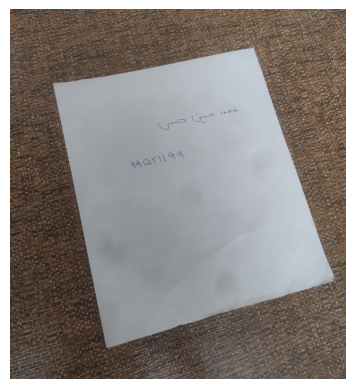

In [74]:
image = cv2.imread(os.path.join('images/Q4', '1.jpg'))
imshow(image)

<h3><font color = "#079e05"> Process </font></h3>

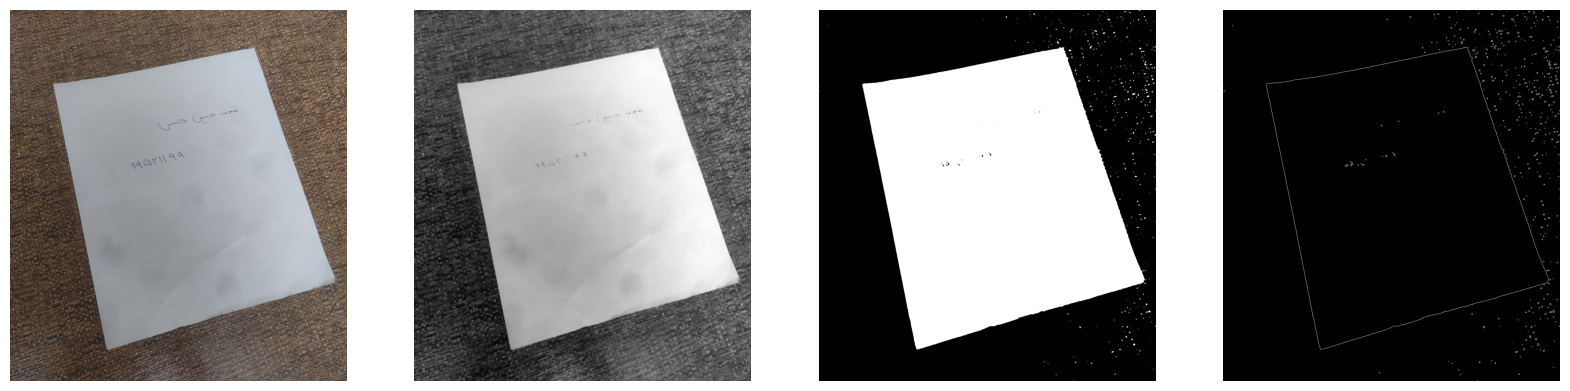

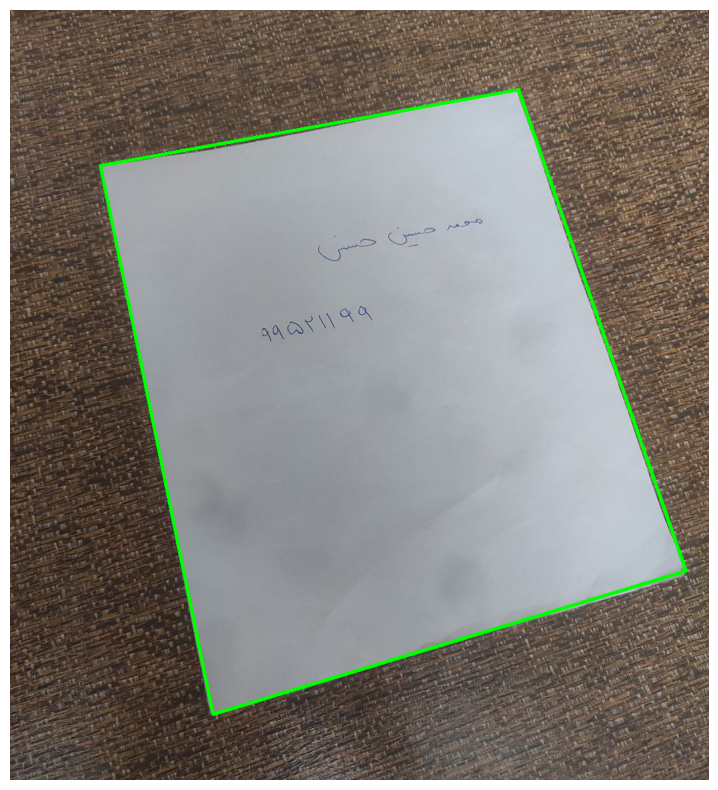

In [75]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply median filter for denoising
denoised_image = cv2.medianBlur(gray_image, 5)

# set value grate than 127 to 255 and less than 127 to 0
ret, thresh = cv2.threshold(denoised_image, 130, 255, cv2.THRESH_BINARY)

# Detect edges using the Canny edge detector
edges = cv2.Canny(thresh, 100, 200)

# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
imshow(image)
plt.subplot(1, 4, 2)
imshow(denoised_image)
plt.subplot(1, 4, 3)
imshow(thresh)
plt.subplot(1, 4, 4)
imshow(edges)
plt.show()

# Find contours in the binary image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with the largest area (this should be the paper)
paper_contour = max(contours, key=cv2.contourArea)

# Approximate the contour to a polygon with fewer vertices
epsilon = 0.1 * cv2.arcLength(paper_contour, True)
approx = cv2.approxPolyDP(paper_contour, epsilon, True)

# Draw the polygon on the original image
cv2.polylines(image, [approx], True, (0, 255, 0), 3)

# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
imshow(image)


# Find the largest 4 contours, assuming that the paper is one of them
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:4]

# Loop over the contours and find the paper contour
paper_contour = None
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    if len(approx) == 4:
        paper_contour = approx
        break

# Reorder the corners of the paper to ensure consistency
paper_corners = reorder(paper_contour.reshape(4, 2))

# Define the dimensions of the output image
width, height = 600, 800

<h3><font color = "#079e05"> Show the result </font></h3>

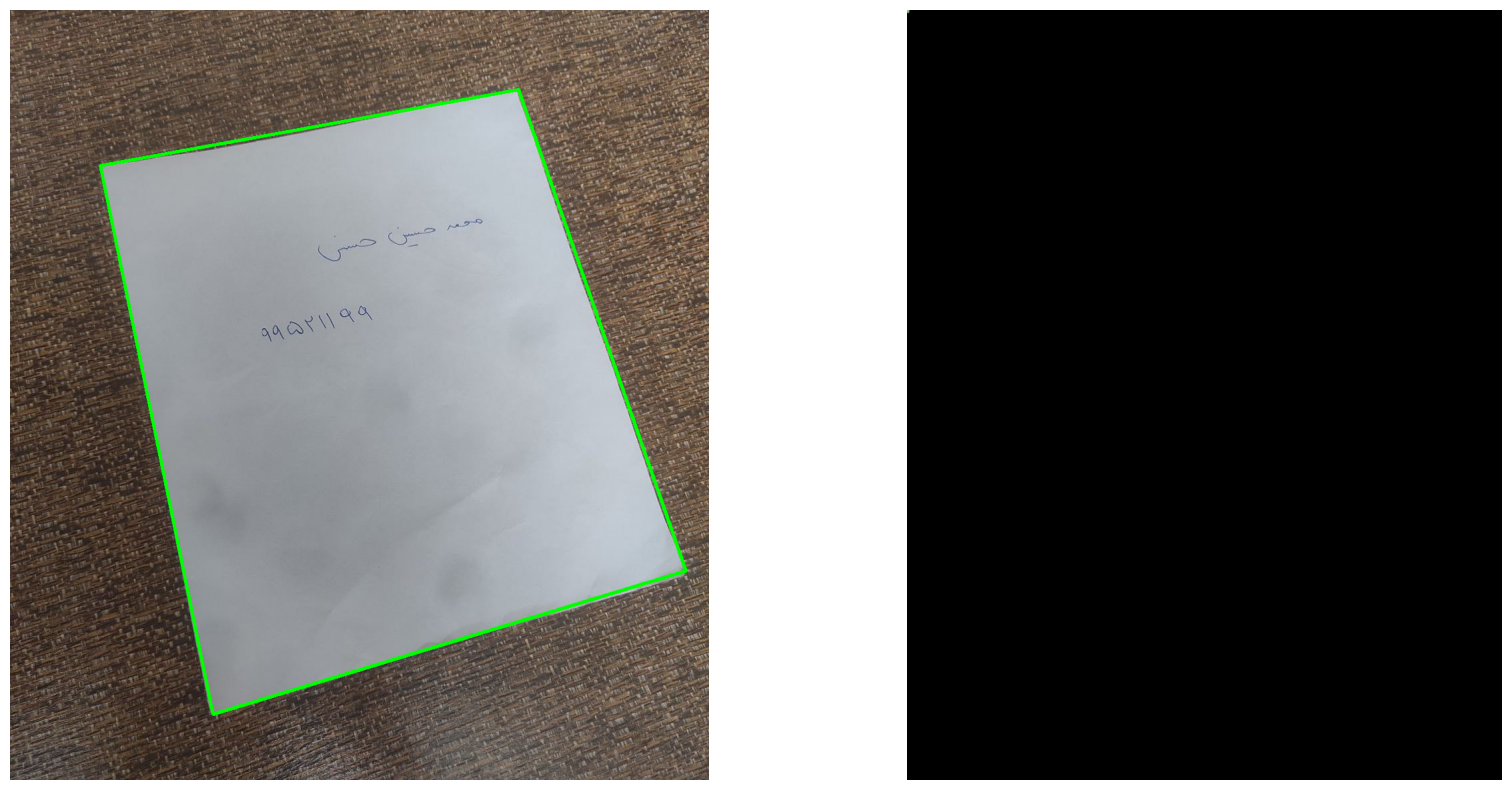

In [76]:
# Define the corners of the paper in the input image
paper_corners = np.float32([corner[0] for corner in approx])

# Define the corners of the paper in the output image (assumes a letter-sized page)
output_corners = np.float32([[0, 0], [0, 11], [8.5, 11], [8.5, 0]])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(paper_corners, output_corners)

# Warp the input image to the output image
output_image = cv2.warpPerspective(image, M, (int(8.5 * 300), int(11 * 300)))

# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
imshow(image)
plt.subplot(1, 2, 2)
imshow(output_image)
plt.show()